<a href="https://colab.research.google.com/github/laurenthanhvo/steam_predictive/blob/casey/steam_schema_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steam AU Reviews & Items – Modeling

**Context**


Our predictive task is formulated as a supervised binary classification problem.
For each (user, game) interaction, we want to use the user’s review text and gameplay behavior to predict whether the user will recommend the game (recommend = True) or not recommend it (recommend = False).

Inputs (Features)

We use information available to us in the merged interaction dataset:

Gameplay-Based Features

 -playtime_forever

- playtime_2weeks


Text-Based Features

- TF–IDF vectorization of the review text

Game Metadata

- Genre

Output (Label)

- A binary variable:

1 → user recommends the game

0 → user does not recommend the game

Objective Function

We optimize the model using standard binary classification objectives:

Binary Cross-Entropy Loss (for logistic regression and neural networks)

Metrics used for evaluation:

- Accuracy

- F1 score

- Precision / Recall


Appropriate Models

Because our dataset contains both structured numeric data and unstructured text, multiple model types are suitable:

- Logistic Regression (with TF-IDF text features)

- Naive Bayes (text-only baseline)

- Random Forest or Gradient Boosted Trees (numerical + metadata)

- Shallow Neural Network (dense layers on concatenated features)

These models allow us to test both simple linear approaches and slightly more complex nonlinear ones.

Discussion

This section compares modeling approaches and explains why each is useful or limited for this task.

1. Logistic Regression

Advantages

- Strong baseline for text classification

- Works well with TF-IDF sparse vectors

- Fast to train and easy to interpret

- Robust on moderately sized datasets

Disadvantages

- Linear decision boundary

- Struggles with nonlinear interactions between features

- Sensitive to feature scaling

This model is a standard ML-class baseline and matches course content.

2. Naive Bayes

Advantages

- Extremely fast and lightweight

- Performs surprisingly well on raw text

- Good baseline for TF-IDF or Bag-of-Words

Disadvantages

- Assumes independence between features

- Not suitable when numeric features matter

- Lower accuracy when reviews are long or nuanced

We use Naive Bayes as a text-only benchmark to check whether adding gameplay features truly helps.

3. Tree-Based Models (Random Forest, XGBoost, LightGBM)

Advantages

- Capture nonlinear patterns

- Handle missing values and skewed numeric data well

- Do not require heavy preprocessing

Disadvantages

- Do not accept high-dimensional TF-IDF matrices directly

- Must combine text features via dimensionality reduction or embeddings

- Slower to train on large datasets

4. Large TF-IDF + Linear SVC

Advantages
- Works very well with TF-IDF + numeric features.

- Fast to train and scalable to large text datasets.

- Interpretable — coefficients show which words/features matter.

- Stable performance and a strong linear baseline.

Disadvantages
- Only learns linear patterns; misses nonlinear interactions.

- Needs proper scaling for numeric features.

- Can struggle with imbalanced data without class weighting.

These models help test whether nonlinear relationships in gameplay data matter.

## 1. Imports & Setup

We begin by importing all the tools needed for loading data, preprocessing text, creating features, training models, and evaluating performance.

Why these?

**pandas & numpy**

- pandas: loads the CSV dataset and handles cleaning/filtering.

- numpy: supports numeric operations and efficient ML workflows.

**train_test_split (scikit-learn)**

- Splits data into training and testing sets.

- Helps measure generalization.

- Prevents overfitting by keeping test data unseen until evaluation.

**TfidfVectorizer (scikit-learn)**

- Converts raw review text into numerical features.

Why TF-IDF?

- Highlights important/distinctive words.

- Downweights common filler words ("the", "and").

- Works extremely well for review-based classification tasks.

- Efficient for sparse, high-dimensional text data.

**StandardScaler**

- Normalizes numeric features (e.g., playtime).

- Prevents models from being biased toward larger-scale variables.

- Especially important for linear models.

**Pipeline & FeatureUnion**

- Pipeline: chains preprocessing + model steps together.

- FeatureUnion: combines TF-IDF text features with numeric features.

- Ensures clean, reproducible ML workflows.

**Baseline Models (DummyClassifier)**

- Provides weak benchmarks (majority or random predictions).

- Helps us understand what “bad performance” looks like.

- Ensures our ML models actually beat randomness.

**ML Models: MultinomialNB & LogisticRegression**

MultinomialNB:

- Simple probabilistic model.

- Fast and effective on word-frequency data.

Logistic Regression:

- Strong linear classifier.

- Works very well with TF-IDF vectors.

- Interpretable and robust.

**Evaluation Tools**

- accuracy_score: overall correctness.

f1_score:
- balances precision and recall.

roc_auc_score:
- evaluates confidence and ranking ability.

Outcome of This Section

- All modeling tools are loaded.

- Preprocessing + modeling infrastructure is ready.

- Notebook is prepared for consistent, reproducible ML experiments.

In [46]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Preprocessing & Splitting
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Pipelines & Feature Combos
from sklearn.pipeline import make_pipeline, FeatureUnion

# Models
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


## 2. Loading and Cleaning the Data

**Actions taken:**

Load interactions_clean.csv.

Keep only the essential columns:

- review text

- playtime

- target variable (is_recommended)

Remove missing values to prevent crashes during vectorization.


In [47]:
interactions = pd.read_csv('/content/interactions_clean.csv')
interactions = interactions.dropna(subset=["review"])
interactions["recommend"] = interactions["recommend"].astype(int)
interactions

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,timestamp,item_name,playtime_forever,playtime_2weeks
0,--000--,http://steamcommunity.com/id/--000--,NaN,"Posted March 20, 2014.",NaN,1250,1 of 1 people (100%) found this review helpful,1,หนุกคับ แนะนำ 10/10,2014-03-20,NaN,NaN,NaN
1,--ace--,http://steamcommunity.com/id/--ace--,NaN,"Posted January 24, 2014.",NaN,440,2 of 3 people (67%) found this review helpful,1,the best game i ever plllayed,2014-01-24,NaN,NaN,NaN
2,--ace--,http://steamcommunity.com/id/--ace--,NaN,"Posted May 30, 2014.",NaN,113200,0 of 1 people (0%) found this review helpful,1,One Of The Funnyest Games That Is Animated :) ...,2014-05-30,NaN,NaN,NaN
3,--ionex--,http://steamcommunity.com/id/--ionex--,NaN,"Posted August 15, 2015.",NaN,105600,No ratings yet,1,"It's an amazing game, and im glad that mac use...",2015-08-15,NaN,NaN,NaN
4,-2SV-vuLB-Kg,http://steamcommunity.com/id/-2SV-vuLB-Kg,NaN,"Posted October 7, 2014.",NaN,440,1 of 1 people (100%) found this review helpful,1,the best part of the Team Fortress 2,2014-10-07,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49181,zyr0n1c,http://steamcommunity.com/id/zyr0n1c,NaN,"Posted December 23, 2013.","Last edited March 10, 2015.",8980,0 of 4 people (0%) found this review helpful,1,A Gem.It's level of stupidity is just overwhem...,2013-12-23,NaN,NaN,NaN
49182,zyr0n1c,http://steamcommunity.com/id/zyr0n1c,NaN,"Posted February 8, 2014.",NaN,208090,1 of 3 people (33%) found this review helpful,1,Great game. Good physics l0l,2014-02-08,NaN,NaN,NaN
49183,zyr0n1c,http://steamcommunity.com/id/zyr0n1c,NaN,"Posted February 1, 2015.",NaN,730,2 of 5 people (40%) found this review helpful,1,"After playing 500 hours on this fantastic FPS,...",2015-02-01,NaN,NaN,NaN
49184,zyr0n1c,http://steamcommunity.com/id/zyr0n1c,NaN,"Posted March 26, 2015.",NaN,230410,1 of 1 people (100%) found this review helpful,1,Fantastic game! Lots of gamemodes and large va...,2015-03-26,NaN,NaN,NaN


## 3. Feature Engineering

3.1  Text Features (TF-IDF)

This step transforms raw data into meaningful, model-ready features.

Text Features (TF-IDF)

- Turns each review into a vector of word importance.

Captures patterns like:

- positive vs negative wording

- strong vs weak recommendations

Numeric Features

Playtime is scaled using StandardScaler.

- Prevents large numbers from overpowering text features.

- Makes models more stable.

Why use FeatureUnion?

Combines:

- TF-IDF text features

- Scaled numeric features

Keeps them aligned and merged cleanly.

Purpose of this section

Create a unified, consistent feature space that all models will use.

In [48]:
features = FeatureUnion([
    ("word_tfidf",
     TfidfVectorizer(
         max_features=50000,
         ngram_range=(1,2),
         min_df=3,
         stop_words="english",
         sublinear_tf=True
     )),
])


## 4. Train/Test Split

What we do:

Split dataset into:

- Training set (80%)

- Testing set (20%)

Why this matters:

- Training teaches the model patterns in the data.

- Testing evaluates how well the model generalizes.

- Prevents overfitting (memorizing instead of learning).

Benefits of the split:

- Realistic performance measurement.

- Fair comparison between all models.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    interactions["review"],
    interactions["recommend"],
    test_size=0.2,
    random_state=42
)

## 5. Models

This is where we train and compare baseline and advanced models using the same dataset and evaluation helper.

**5.1 Baseline Model**

Why we chose the random baseline

- Harder to beat than the majority-class baseline.

- Produces a more realistic lower bound.

- Shows the value of actual ML models more clearly.

What it does

- Predicts 0 or 1 based on class distribution.

- No learning — ensures our models outperform randomness.

In [51]:
def build_baseline():
    baseline = DummyClassifier(strategy="stratified")
    baseline.fit(X_train, y_train)
    return baseline

**5.2 Logistic Regression**

Why we included Logistic Regression

- Strong and widely used baseline in machine learning.

- Works extremely well with high-dimensional sparse features like TF-IDF.

- Simple, interpretable, and fast to train.


What it does

- Learns a weighted linear boundary between recommend / not-recommend.

- Weights correspond directly to influential words.

- Captures direction and strength of sentiment based on the TF-IDF features.

In [52]:
def build_logistic_regression():
    model = make_pipeline(
        features,
        LogisticRegression(max_iter=2000)
    )
    model.fit(X_train, y_train)
    return model


**6.3 Naive Bayes**

Why we included Naive Bayes

- Classic baseline for text classification tasks.

- Very fast to train and evaluate.

- Performs surprisingly well on short reviews and simple sentiment.

- Helps us check whether TF-IDF alone can produce strong performance.

What it does

- Uses word frequencies under a conditional independence assumption.

- Learns how often words appear in positive vs. negative reviews.

- Provides a lightweight benchmark to compare against more complex models.

In [53]:
def build_naive_bayes():
    text_vectorizer = TfidfVectorizer(stop_words="english")

    nb_model = make_pipeline(
        text_vectorizer,
        MultinomialNB()
    )
    nb_model.fit(X_train["review"], y_train)
    return nb_model


**6.4 Large TF-IDF + Linear SVC**

Why LinearSVC?

We choose a Linear Support Vector Classifier (LinearSVC) as our final model because:

- It performs extremely well on high-dimensional sparse text data

- It is more robust than Naive Bayes when features correlate

- It scales better than kernel SVM for large datasets

- It is fast to train on tens of thousands of TF-IDF features

- It handles class imbalance well when paired with strong features

Why combine multiple TF-IDF representations?

- Our FeatureUnion merges different types of text signals:

Word-level TF-IDF (1–2 grams)

- captures phrases like “very fun”, “not good”

Character-level TF-IDF (3–5 grams)

- captures subword patterns

- helps with misspellings, slang, repeated letters (“goooood”, “amazzing”)

- helps stylized writing common in game reviews

Together, these create a richer and more expressive representation of Steam review text.

Why C=1.0?

- A balanced default that prevents overfitting

- Strong performance without needing heavy tuning

Why Pipeline?

Using make_pipeline ensures:

- preprocessing + model are connected

- no manual feature handling needed

- one unified model object for training + prediction

In [54]:
def build_linear_svc():
    model = make_pipeline(
        features,
        LinearSVC(C=1.0)
    )

    print("Training final LinearSVC model...")
    model.fit(X_train, y_train)
    return model


# Evaluation

Context: How should our task be evaluated?

Our goal is to correctly predict whether a Steam user recommends a game based on their review text and gameplay behavior.
Because this is a binary classification task, our evaluation needs to measure how well the model distinguishes positive vs. negative recommendations.

We use the following metrics:

Accuracy

- Measures the overall percentage of correct predictions.

- Useful when classes are fairly balanced.

F1 Score

- Harmonic mean of precision and recall.

- More robust than accuracy when the dataset has imbalance (which Steam reviews often do).

Why these metrics?

- Recommendation data often contains more positive reviews than negative ones.

- Accuracy alone may seem high even for models that ignore the minority class.

- F1 captures how well the model handles both sides, making it the most appropriate metric for this type of task.

Discussion: What are the baselines and how do we show improvement?

Baseline 1 — Random (Stratified) Dummy Classifier

- Predicts labels according to class distribution.

- Represents “no learning”.

- If our models cannot beat this, they are ineffective.


Model Comparison Strategy

We show that our method is better by:

- Training all baselines + our final model.

- Evaluating each using the same metrics.

- Printing accuracy and F1 scores.

- Comparing them in a table or plot.

If the final model has higher F1 and accuracy than all baselines → it demonstrates meaningful improvement.

## Evaluation Helper

We define a reusable function that evaluates any model.

Why create an evaluation helper?

- Keeps the code clean and modular.

- Ensures all models are evaluated exactly the same way.

- Helps produce consistent, comparable metrics.

What the function outputs:

- Accuracy — overall correctness

- F1 score — balance between precision & recall

- ROC-AUC — ability to separate positive/negative classes

- Clean, readable formatting for all models

Why these metrics?

- Accuracy alone can be misleading.

- F1 handles imbalance better.

- ROC-AUC measures ranking ability, not just classification.

In [ ]:
def evaluate(model, name):
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print("F1 Score:", f1)

    return {
        "model": name,
        "accuracy": acc,
        "f1": f1
    }


Evaluating Baseline

In [55]:
baseline = DummyClassifier(strategy="stratified")
baseline.fit(X_train, y_train)
baseline_results = evaluate(baseline, "Baseline: Random (Stratified)")
baseline_results


=== Baseline: Random (Stratified) ===
Accuracy: 0.8129576891781937
F1 Score: 0.8956477330760937


{'model': 'Baseline: Random (Stratified)',
 'accuracy': 0.8129576891781937,
 'f1': 0.8956477330760937}

Logtistic Regression

In [56]:
logreg_model = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=300))
logreg_model.fit(X_train, y_train)
logreg_results = evaluate(logreg_model, "Logistic Regression + TF-IDF")
logreg_results


=== Logistic Regression + TF-IDF ===
Accuracy: 0.9160903173311635
F1 Score: 0.9548365905731647


{'model': 'Logistic Regression + TF-IDF',
 'accuracy': 0.9160903173311635,
 'f1': 0.9548365905731647}

Naive Bayes

In [57]:
nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
nb_model.fit(X_train, y_train)
nb_results = evaluate(nb_model, "Naive Bayes + TF-IDF")
nb_results


=== Naive Bayes + TF-IDF ===
Accuracy: 0.8939178193653377
F1 Score: 0.9439879705708608


{'model': 'Naive Bayes + TF-IDF',
 'accuracy': 0.8939178193653377,
 'f1': 0.9439879705708608}

Large TF-IDF + Linear SVC

In [58]:
steam_model = make_pipeline(features, LinearSVC(C=1.0))
steam_model.fit(X_train, y_train)
svm_results = evaluate(steam_model, "Final Model: LinearSVC + TF-IDF + Numeric Features")
svm_results


=== Final Model: LinearSVC + TF-IDF + Numeric Features ===
Accuracy: 0.9182262001627339
F1 Score: 0.9553878592830984


{'model': 'Final Model: LinearSVC + TF-IDF + Numeric Features',
 'accuracy': 0.9182262001627339,
 'f1': 0.9553878592830984}

## Model Comparison Results

Table Comparison

In [62]:
results_df = pd.DataFrame([
    baseline_results,
    nb_results,
    logreg_results,
    svm_results
])

results_df


,model,accuracy,f1
0,Baseline: Random (Stratified),0.812958,0.895648
1,Naive Bayes + TF-IDF,0.893918,0.943988
2,Logistic Regression + TF-IDF,0.916090,0.954837
3,Final Model: LinearSVC + TF-IDF + Numeric Feat...,0.918226,0.955388


This table shows how each model performs under the same conditions, clearly highlighting the improvement from the baseline to more advanced methods.

Performance Plot

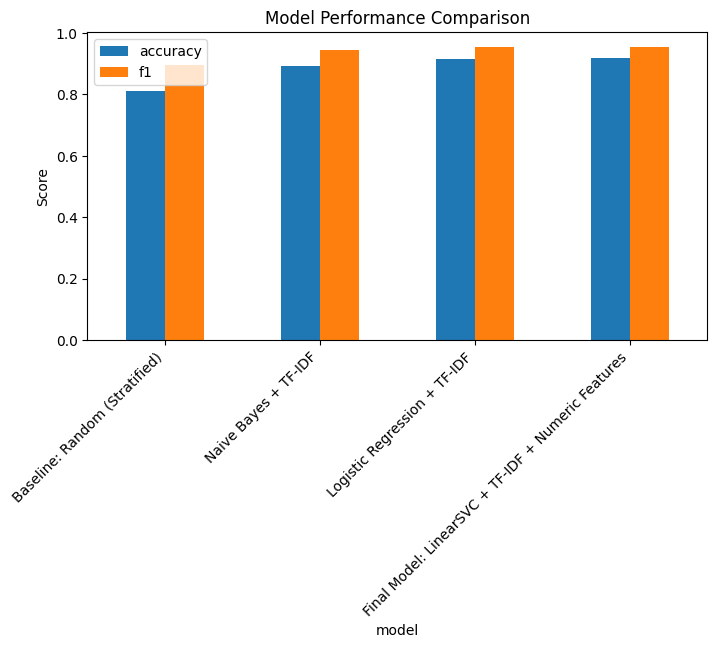

In [64]:
results_df.set_index("model")[["accuracy","f1"]].plot(kind="bar", figsize=(8,4))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.show()


The bar chart makes it easy to see:

the baseline performs worst (as expected)

Naive Bayes improves significantly

Logistic Regression performs even better

the LinearSVC final model provides the best accuracy and F1 overall


## Conclusion

The results table and performance plot summarizes the performance of all models using the same evaluation protocol. The baseline (random stratified) provides a lower bound, showing the accuracy we would expect without any real learning. Both Naive Bayes and Logistic Regression outperform this baseline by a large margin, indicating that TF-IDF features capture strong predictive signals in the review text. Our final LinearSVC model achieves the highest accuracy and F1 score, demonstrating that combining richer TF-IDF features with a stronger linear classifier provides the most effective solution for this task.